In [1]:
import pandas as pd
import reverse_geocoder as rg
from pathlib import Path
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
import numpy as np

loc_df = pd.read_csv('CountryCodes.csv')
loc_df.head(10)

,Unnamed: 0,Lat,Long,Venue_Type,Venue_Name,Created_On_Epoch,Created_On,Quarter,Year,Month,latlong,Country,City
0,0,10.377644,-75.496582,food,QUESOS NENECO,1564682328,8/1/2019,Quarter 3,2019,8,"(10.37764401, -75.49658239)",CO,Cartagena
1,1,40.647499,22.920163,default,Ταπετσαρίες αυτοκινήτων - ΚΑΡΑΜΠΕΡΗΣ ΧΡΗΣΤΟΣ,1530718484,7/4/2018,Quarter 3,2018,7,"(40.64749893, 22.92016268)",GR,Ampelokipoi
2,2,42.000524,12.564636,food,AZIENDA AGRICOLA FORTUNATO,1551976752,3/7/2019,Quarter 1,2019,3,"(42.00052447, 12.56463647)",IT,Tor Lupara
3,3,-23.558042,-46.660100,shopping,KriptoBR,1534775809,8/20/2018,Quarter 3,2018,8,"(-23.55804222, -46.66009963)",BR,Sao Paulo
4,4,45.539970,13.734852,shopping,"Buzz, Planet Koper",1574094032,11/18/2019,Quarter 4,2019,11,"(45.53996976, 13.73485208)",SI,Koper
5,5,10.181132,-68.005028,default,Soporte PC y Criptomonedas,1551983266,3/7/2019,Quarter 1,2019,3,"(10.18113243, -68.00502777)",VE,Valencia
6,6,22.326323,114.205676,food,Wandersnack,1564727493,8/2/2019,Quarter 3,2019,8,"(22.32632341, 114.2056757)",HK,Kowloon
7,7,46.068307,14.543801,default,Clarus Dental,1571312234,10/17/2019,Quarter 4,2019,10,"(46.06830686, 14.54380095)",SI,Ljubljana
8,8,46.056131,14.508138,cafe,Trot Bar,1571312941,10/17/2019,Quarter 4,2019,10,"(46.05613139, 14.5081383)",SI,Ljubljana
9,9,33.491607,49.052528,default,فروشگاه پرکنی,1540247322,10/22/2018,Quarter 4,2018,10,"(33.49160726, 49.05252814)",IR,Dorud


In [2]:
country_codes_df = pd.read_csv('continent_code_list.csv')
country_codes_df = country_codes_df.iloc[:,0:5]

# We have an issue: duplicate countries in different continents??
country_codes_df[country_codes_df.Two_Letter_Country_Code == 'AZ']

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code
8,Europe,EU,"Azerbaijan, Republic of",AZ,AZE
9,Asia,AS,"Azerbaijan, Republic of",AZ,AZE


In [3]:
country_codes_df = country_codes_df.drop_duplicates('Two_Letter_Country_Code')
country_codes_df

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG
1,Europe,EU,"Albania, Republic of",AL,ALB
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA
4,Oceania,OC,American Samoa,AS,ASM
...,...,...,...,...,...
257,Africa,AF,"Zambia, Republic of",ZM,ZMB
258,Oceania,OC,Disputed Territory,XX,NaN
259,Asia,AS,Iraq-Saudi Arabia Neutral Zone,XE,NaN
260,Asia,AS,United Nations Neutral Zone,XD,NaN


In [4]:
# merge this into our original df
loc_df = loc_df.merge(country_codes_df, right_on='Two_Letter_Country_Code', left_on='Country', how='left')
loc_df.drop(['Two_Letter_Country_Code'], axis = 1)

,Unnamed: 0,Lat,Long,Venue_Type,Venue_Name,Created_On_Epoch,Created_On,Quarter,Year,Month,latlong,Country,City,Continent_Name,Continent_Code,Country_Name,Three_Letter_Country_Code
0,0,10.377644,-75.496582,food,QUESOS NENECO,1564682328,8/1/2019,Quarter 3,2019,8,"(10.37764401, -75.49658239)",CO,Cartagena,South America,SA,"Colombia, Republic of",COL
1,1,40.647499,22.920163,default,Ταπετσαρίες αυτοκινήτων - ΚΑΡΑΜΠΕΡΗΣ ΧΡΗΣΤΟΣ,1530718484,7/4/2018,Quarter 3,2018,7,"(40.64749893, 22.92016268)",GR,Ampelokipoi,Europe,EU,"Greece, Hellenic Republic",GRC
2,2,42.000524,12.564636,food,AZIENDA AGRICOLA FORTUNATO,1551976752,3/7/2019,Quarter 1,2019,3,"(42.00052447, 12.56463647)",IT,Tor Lupara,Europe,EU,"Italy, Italian Republic",ITA
3,3,-23.558042,-46.660100,shopping,KriptoBR,1534775809,8/20/2018,Quarter 3,2018,8,"(-23.55804222, -46.66009963)",BR,Sao Paulo,South America,SA,"Brazil, Federative Republic of",BRA
4,4,45.539970,13.734852,shopping,"Buzz, Planet Koper",1574094032,11/18/2019,Quarter 4,2019,11,"(45.53996976, 13.73485208)",SI,Koper,Europe,EU,"Slovenia, Republic of",SVN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,6900,46.032223,14.459006,sports,Tenis Schweiger,1589897799,5/19/2020,Quarter 2,2020,5,"(46.03222305, 14.45900559)",SI,Vnanje Gorice,Europe,EU,"Slovenia, Republic of",SVN
6901,6901,46.024666,14.531146,cafe,Kavarnica Green,1589898116,5/19/2020,Quarter 2,2020,5,"(46.02466599, 14.53114629)",SI,Lavrica,Europe,EU,"Slovenia, Republic of",SVN
6902,6902,46.251793,15.165194,shopping,Kreativna Fabrika online store,1589898486,5/19/2020,Quarter 2,2020,5,"(46.25179255, 15.16519368)",SI,Zalec,Europe,EU,"Slovenia, Republic of",SVN
6903,6903,46.560155,15.649150,shopping,dernier | Final difference online store,1589898698,5/19/2020,Quarter 2,2020,5,"(46.56015499, 15.64915001)",SI,Maribor,Europe,EU,"Slovenia, Republic of",SVN


In [5]:
# loc_df.resample('M', on='Created_On').sum()
loc_df['M-Y'] = pd.to_datetime(loc_df[['Year', 'Month']].assign(DAY=1)).dt.date
loc_df['M-Y']

0       2019-08-01
1       2018-07-01
2       2019-03-01
3       2018-08-01
4       2019-11-01
           ...    
6900    2020-05-01
6901    2020-05-01
6902    2020-05-01
6903    2020-05-01
6904    2020-05-01
Name: M-Y, Length: 6905, dtype: object

In [6]:
month_data = loc_df['M-Y'].value_counts()
month_data

2020-03-01    756
2018-11-01    575
2018-01-01    475
2018-05-01    308
2018-02-01    301
2018-07-01    278
2018-03-01    267
2018-09-01    253
2019-04-01    252
2019-01-01    247
2018-04-01    247
2019-05-01    244
2019-08-01    236
2018-10-01    234
2019-11-01    233
2018-06-01    192
2019-09-01    189
2018-12-01    178
2018-08-01    172
2019-07-01    171
2019-06-01    168
2019-02-01    164
2019-03-01    156
2019-10-01    139
2020-02-01    135
2019-12-01    120
2020-01-01    107
2020-04-01     55
2020-05-01     53
Name: M-Y, dtype: int64

In [7]:
import geopandas
# convert to geopandas df
gdf = geopandas.GeoDataFrame(loc_df, geometry=geopandas.points_from_xy(loc_df.Long, loc_df.Lat))
print(gdf.head())

   Unnamed: 0        Lat       Long Venue_Type  \
0           0  10.377644 -75.496582       food   
1           1  40.647499  22.920163    default   
2           2  42.000524  12.564636       food   
3           3 -23.558042 -46.660100   shopping   
4           4  45.539970  13.734852   shopping   

                                     Venue_Name  Created_On_Epoch  Created_On  \
0                                 QUESOS NENECO        1564682328    8/1/2019   
1  Ταπετσαρίες αυτοκινήτων - ΚΑΡΑΜΠΕΡΗΣ ΧΡΗΣΤΟΣ        1530718484    7/4/2018   
2                    AZIENDA AGRICOLA FORTUNATO        1551976752    3/7/2019   
3                                      KriptoBR        1534775809   8/20/2018   
4                            Buzz, Planet Koper        1574094032  11/18/2019   

     Quarter  Year  Month                       latlong Country         City  \
0  Quarter 3  2019      8   (10.37764401, -75.49658239)      CO    Cartagena   
1  Quarter 3  2018      7    (40.64749893, 22.920162

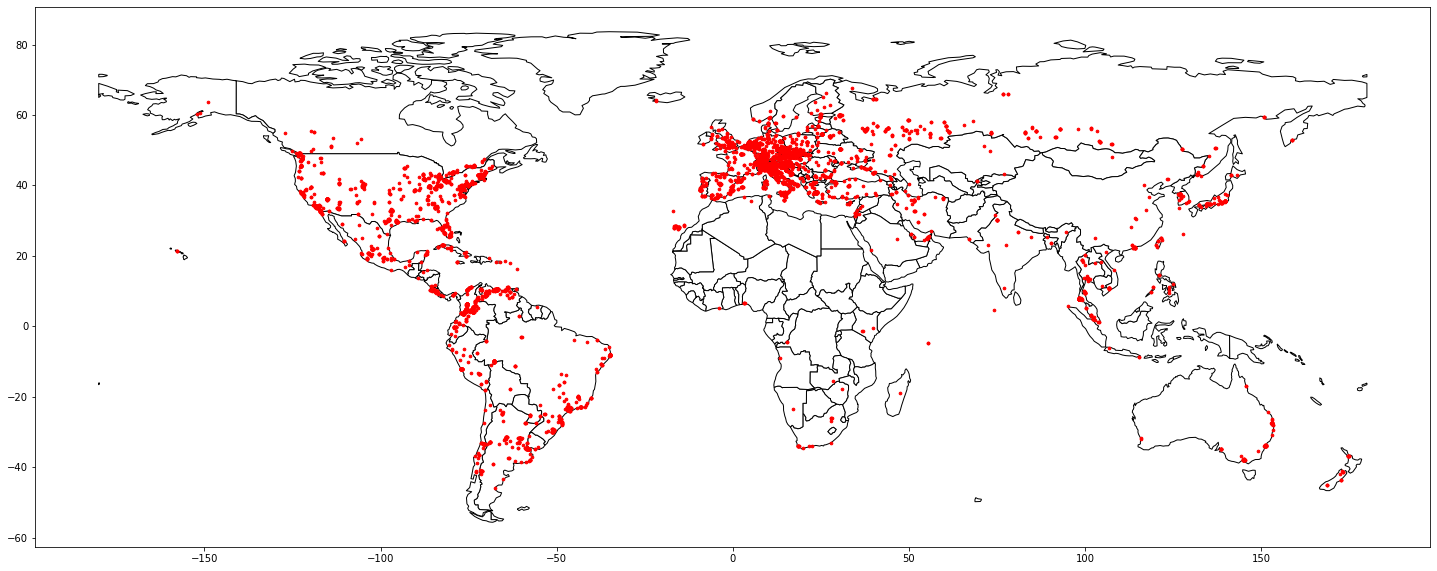

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# South America.
ax = world[world.continent != 'Antarctica'].plot(color='white', edgecolor='black', figsize = (25,25))

# plot GeoDataFrame.
gdf.plot(ax=ax, color='red', markersize = 7)
plt.show()

In [19]:
# get the values of each country(code)
cc_srs = loc_df['Three_Letter_Country_Code'].value_counts()
cc_df = cc_srs.to_frame().reset_index()
cc_df.columns = ['threeCC','Num_New_Vendors']

In [20]:
from geopandas_view import view

In [21]:
# Convert value counts series to geopandas

cc_gdf = geopandas.GeoDataFrame(cc_df)

# Get world dataset and add above data to it
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()
world = world.merge(cc_gdf, left_on = 'iso_a3', right_on = 'threeCC', how='left')
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,threeCC,Num_New_Vendors
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,88.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,874.0
...,...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",SRB,4.0
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",MNE,2.0
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TTO,2.0


<AxesSubplot:>

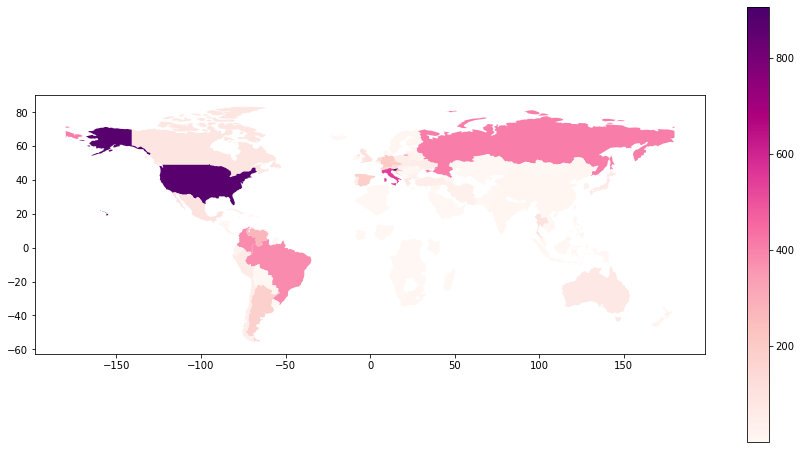

In [22]:
world.plot(column = 'Num_New_Vendors', cmap='RdPu', figsize = (15,8), legend=True)

In [23]:
world['Num_New_Vendors'] = np.log(world['Num_New_Vendors'])

<AxesSubplot:>

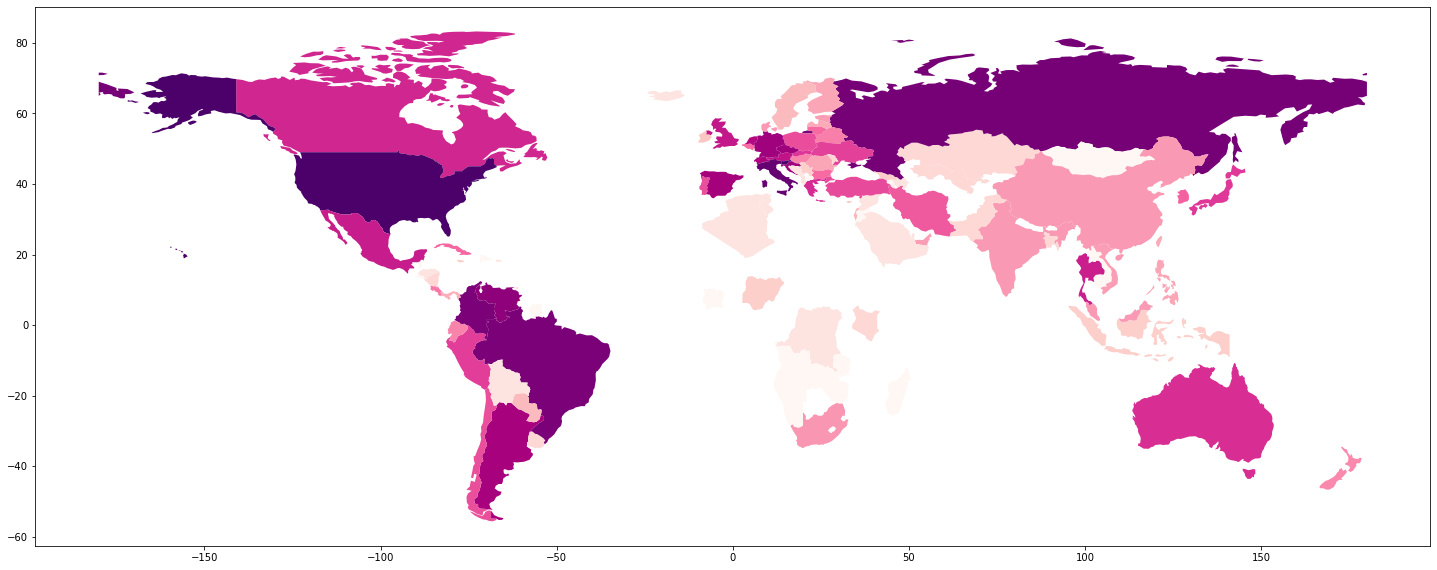

In [14]:
world.plot(column = 'Num_New_Vendors', cmap='RdPu', figsize = (25,25))

<AxesSubplot:>

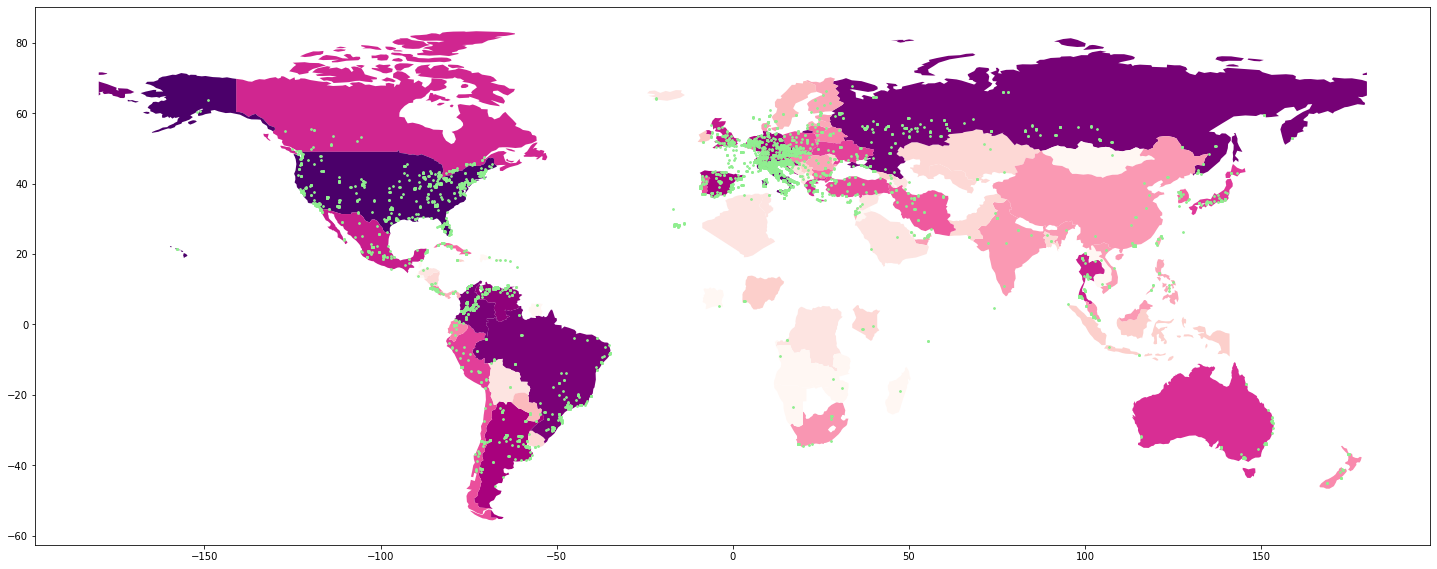

In [15]:
base = world.plot(column = 'Num_New_Vendors', cmap='RdPu', figsize = (25,25))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=base, color='lightgreen', markersize = 3, legend=True, scheme='quantiles')


In [16]:
eur_countries = world[world.continent == 'Europe'][world.name != 'Russia']
eur_countries

eur_gdf = gdf[gdf.Continent_Name == 'Europe'][gdf.Country_Name != 'Russian Federation']
eur_gdf['Country_Name'].value_counts()

/Users/pritam/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


Slovenia, Republic of                                 906
Italy, Italian Republic                               544
Croatia, Republic of                                  214
Czech Republic                                        206
Germany, Federal Republic of                          206
Spain, Kingdom of                                     187
Switzerland, Swiss Confederation                      166
Netherlands, Kingdom of the                           146
Austria, Republic of                                  122
United Kingdom of Great Britain & Northern Ireland    112
Greece, Hellenic Republic                              82
Slovakia (Slovak Republic)                             69
France, French Republic                                58
Ukraine                                                57
Turkey, Republic of                                    49
Poland, Republic of                                    47
Portugal, Portuguese Republic                          45
Lithuania, Rep

In [17]:
dir(eur_countries[eur_countries['name'] == 'France'].geometry)
eur_countries[eur_countries['name'] == 'France'].geometry

43    MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...
Name: geometry, dtype: geometry

<AxesSubplot:>

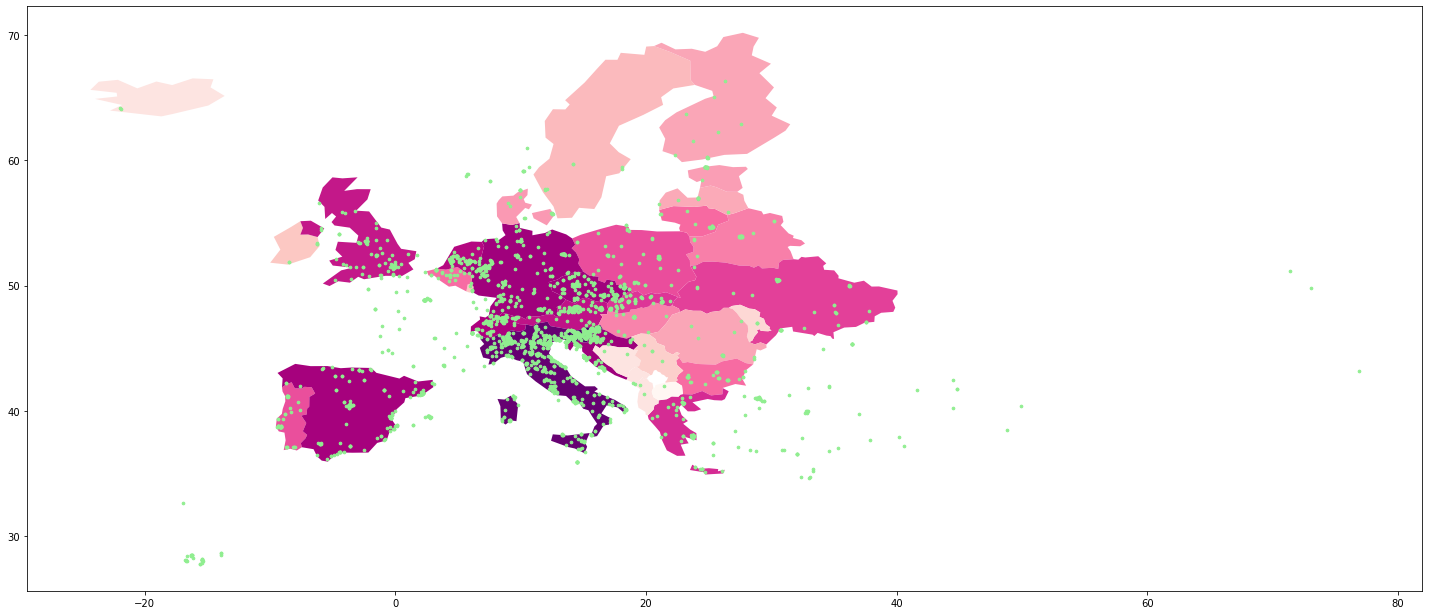

In [18]:
base = eur_countries.plot(column = 'Num_New_Vendors', cmap='RdPu', figsize = (25,25))

# We can now plot our ``GeoDataFrame``.
eur_gdf.plot(ax=base, color='lightgreen', markersize = 7, legend=True, scheme='quantiles')